# Map-based heterogeneous model optimization using an evolutionary approach

The model we have used in the previous tutorials was a **homogeneous** model. In a homogeneous model we assume that the regional parameters (in rWW model with FIC: $w^{p}$ and $J^{N}$) are the same across all nodes in the simulation. While homogeneous models have traditionally been the standard in the field, more recent studies have introduced the concept of **heterogeneous** (or **parametric**) models. In heterogeneous models, within a given simulation, regional parameters are allowed to vary across nodes, in one of two ways:
- Map-based heterogeneity: Parameters vary systematically based on one or more fixed biological maps.
- Node-based heterogeneity: Parameters vary independently across nodes or node groups (e.g., by resting-state networks or bilateral homologs).

The cuBNM toolbox supports both approaches.

In this tutorial, we will focus on a map-based heterogeneous rWW model with FIC. In this model, each regional parameter in each node, $P_i,\ P\ \in\ {w^{p},\ J^{N}}$ is calculated as:

$$
P_i=\ P_b\ .\ (1+\sum_{k=1}^{Nmaps}{c_k^PM_{ki}})
$$

where $P_b$ is a baseline (bias) value for parameter $P$; $c_k^P$ are the coefficents for each map $k$ determining parameter $P$; $M_{ki}$ is the value of (fixed) map $k$ at node $i$

In this tutorial the maps $M$ includes two features derived from the Human Connectome Project (HCP), parcellated in Schaefer-100 atlas and normalized to a range of \[0, 1\]:

- T1w/T2w, a putative marker of myelination:

<div style="text-align: center;">
  <img src="myelinmap.png" width="500"/>
</div>

- Principal functional connectivity gradient (FC G1):
<div style="text-align: center;">
  <img src="fcg1.png" width="500"/>
</div>

These two maps (in addition to a few other maps) are included in the toolbox and are available in some of the standard parcellations, including Schaefer-100 which we will use here.

## Loading the maps

We can load these maps in Schaefer-100 parcellation using `cubnm.datasets.load_maps`:

In [1]:
from cubnm import datasets

maps = datasets.load_maps(['myelinmap', 'fcgradient01'], parc='schaefer-100', norm='minmax')
maps.shape

(2, 100)

This returns a 2D NumPy array of shape `(n_maps, n_nodes)`. For the Schaefer-100 parcellation, this will be `(2, 100)`. Note that by setting `norm='minmax'`, each map is normalized to the \[0,1\] range.

## Defining a map-based heterogeneous BNM problem

To incorporate heterogeneity in our model, we need to pass the `maps` and specify which regional parameters should vary across nodes using the `het_params` argument when creating the `BNMProblem`.

In this example, we want both `'w_p'` and `'J_N'` to be heterogeneous, so we set:

In [2]:
het_params = ['w_p', 'J_N']

We also optionally specify the range for the map coefficients using the `maps_coef_range` argument. Here, we set it to `(-5, 5)` for both maps.

<div class="alert alert-info">
<p>
Note: The `maps_coef_range` arguments is by default set to `'auto'`, which will set the range of coefficients for all-positive maps (such as 0-1 normalized maps) to [0, 1], and for maps including negative and positive values (such as Z-scored maps) to [-1/max(map), -1/min(map)].
</p>
</div>

<div class="alert alert-info">
<p>
Note: When the maps and their coefficients result in regional parameter values that are outside the defined bound, the out-of-bound end will be set to the lower/upper end of the bound. Then the rest of the values will be re-normalized. By default the bound for the regional values, defined using the `het_params_range` argument, is the same as the range of baseline values (defined in `params` dictionary), but it can be modified to a different range.
</p>
</div>

All other arguments to `BNMProblem`, including the empirical data and simulation options, remain similar to those used in previous tutorials.

In [3]:
from cubnm import optimize

# load structural connectome
sc = datasets.load_sc('strength', 'schaefer-100', 'group-train706')
# load empirical FC tril and FCD tril
emp_fc_tril = datasets.load_fc('schaefer-100', 'group-train706', exc_interhemispheric=True, return_tril=True)
emp_fcd_tril = datasets.load_fcd('schaefer-100', 'group-train706', exc_interhemispheric=True, return_tril=True)

sim_options = dict(
    duration=900,
    bold_remove_s=30,
    TR=0.72,
    sc=sc,
    sc_dist=None,
    dt='0.1',
    bw_dt='1.0',
    ext_out=True,
    states_ts=False,
    states_sampling=None,
    noise_out=False,
    sim_seed=0,
    noise_segment_length=30,
    gof_terms=['+fc_corr', '-fcd_ks'],
    do_fc=True,
    do_fcd=True,
    window_size=30,
    window_step=5,
    fcd_drop_edges=True,
    exc_interhemispheric=True,
    bw_params='heinzle2016-3T',
    sim_verbose=False,
    do_fic=True,
    max_fic_trials=0,
    fic_penalty_scale=0.5,
)

# define the **map-based heterogeneous** problem
problem = optimize.BNMProblem(
    model = 'rWW',
    params = {
        'G': (0.001, 10.0), 
        'w_p': (0, 2.0),
        'J_N': (0.001, 0.5)
    },
    emp_fc_tril= emp_fc_tril,
    emp_fcd_tril= emp_fcd_tril,
    het_params = het_params,
    maps = maps,
    maps_coef_range = (-5, 5),
    out_dir = './cmaes_het',
    **sim_options
)

Simply passing the `het_params` and `maps` arguments to `BNMProblem` is enough to create a map-based heterogeneous BNM problem.

We can inspect the list of free parameters defined in the `problem`:

In [4]:
problem.free_params

['G', 'w_p', 'J_N', 'w_pscale0', 'w_pscale1', 'J_Nscale0', 'J_Nscale1']

This shows that the model has 7 free parameters, including:

- `'G'`: The global coupling parameter, same as with the homogeneous models.
- `'w_p'`, `'J_N'`: Baseline values (bias terms) for the regional parameters.
- `'*scale{i}'`: Map coefficients used for map index `i` to determine regional parameter $w^{p}$ or $J^{N}$.

<div class="alert alert-info">
<p>
The `free_params` listed in `BNMProblem` represent the tunable high-level parameters for optimization. These differ from the lower-level model parameters in `SimGroup`, which include:
<ul>
    <li>`'G'`</li>
    <li>Node-specific values (N = number of nodes) for `'w_p'`, `'J_N'`, and `'wIE'` (the latter is internally determined by the FIC algorithm and set to zero during setup).</li>
</ul>
</p>
</div>

## Running a single map-based heterogeneous simulation

To show how map-based heterogeneity works in practice, we’ll run a single example simulation using an arbitrary set of free parameters:

In [5]:
example_params = {
    'G': 2.5,
    'w_p': 1.2,
    'J_N': 0.15,
    'w_pscale0': 0.5,
    'w_pscale1': -0.8,
    'J_Nscale0': 0.6,
    'J_Nscale1': -0.7,
}

We can then use the `problem.eval()` method to run a simulation using these arbitrary free parameters. Internally, this will set the regional values of the parameters based on the provided baseline values (`'w_p'` and `'J_N'`), coefficients (`'*scale{i}`) and the maps (`problem.maps`). Next, it will run the simulation (or simulations, when multiple sets of free parameters are provided, as occurs during optimization), and evaluate it against the empirical functional data, returning the goodness-of-fit values, FIC penalty and the cost function.

<div class="alert alert-info">
<p>
Note: The combination of provided free parameters and the maps may lead to negative values for some of the regional parameters and in the current models included in the toolbox none of the regional parameters should be negative. When negative values occur, the regional parameter values are shifted so that the lowest regional value is +0.001. 

This behavior may change in future versions to reject such parameter sets instead of shifting them.
</p>
</div>

Internally, optimizers represent the ranges of all free parameters as [0, 1] in the **normalized** parameter space (with parameters denoted as `X`). Before applying parameters to the model, `BNMProblem` transforms these values to the **actual** parameter space (denoted as `Xt`), using the ranges defined in `params` and `maps_coef_range`. The `problem.eval()` method expects a 2D array of shape `(n_simulations, n_free_parameters)` in normalized space. Therefore, before evaluating our example parameters, we need to convert them to a 2D NumPy array, and transform them from actual to normalized space usign `problem._get_X()`. 

<div class="alert alert-info">
<p>
Note: This transformation is only needed in this example simulation where we are manually calling `problem.eval()`.
During optimization, the optimizer handles all required transformations internally.
</p>
</div>

In [6]:
import pandas as pd

# convert example parameters to a 2D array
Xt = pd.Series(example_params).to_frame().T.values
# transform them to normalized space
X = problem._get_X(Xt)

print("free parameters", problem.free_params)
print("parameters in actual space", Xt)
print("lower bound of parameter ranges", problem.lb)
print("upper bound of parameter ranges", problem.ub)
print("parameters in normalized space", X)

free parameters ['G', 'w_p', 'J_N', 'w_pscale0', 'w_pscale1', 'J_Nscale0', 'J_Nscale1']
parameters in actual space [[ 2.5   1.2   0.15  0.5  -0.8   0.6  -0.7 ]]
lower bound of parameter ranges [ 1.e-03  0.e+00  1.e-03 -5.e+00 -5.e+00 -5.e+00 -5.e+00]
upper bound of parameter ranges [10.   2.   0.5  5.   5.   5.   5. ]
parameters in normalized space [[0.24992499 0.6        0.29859719 0.55       0.42       0.56
  0.43      ]]


Now we can pass on normalized parameters to `problem.eval()` method and evaluate the simulation based on this set of arbitrary parameters:

In [7]:
scores = problem.eval(X)
scores

Initializing GPU session...
took 3.528136 s
Running 1 simulations...
took 29.955680 s


,+fc_corr,-fcd_ks,+gof,-fic_penalty
0,0.210258,-0.88695,-0.676692,-0.353201


The scores from the evaluation are not particularly good, but this is expected, as we haven't optimized the model parameters yet.
Before moving on to optimization, let's inspect how the regional parameters were set based on our example free parameters and the provided maps.

When `problem.eval()` is called, BNMProblem internally computes the node-wise values of `'w_p'` and `'J_N'` based on the maps and the optimizer free parameters, and sets them in `problem.sim_group.param_lists`.

We can visualize these regional parameter arrays next to the original maps:

,w_p,J_N
count,100.000000,100.000000
mean,1.036750,0.143172
std,0.426212,0.051950
min,0.308587,0.055193
25%,0.601219,0.095427
50%,1.021071,0.144337
75%,1.424775,0.190812
max,1.795665,0.239350


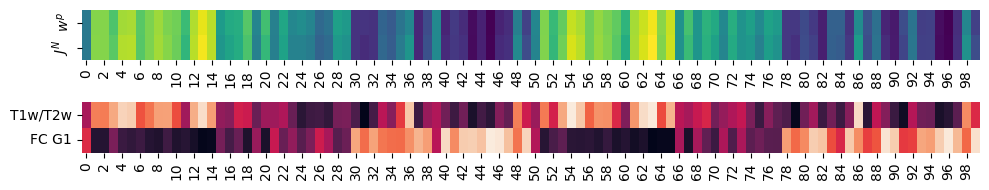

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

# plot regional parameters arrays next to the maps arrays
regional_params = pd.DataFrame({
    'w_p': problem.sim_group.param_lists['w_p'][0],
    'J_N': problem.sim_group.param_lists['J_N'][0]
})

maps_df = pd.DataFrame({
    'T1w/T2w': problem.maps[0],
    'FC G1': problem.maps[1]
})

fig, axes = plt.subplots(2, 1, figsize=(10, 2))
# z-score parameters in the visualization given their different ranges
sns.heatmap(scipy.stats.zscore(regional_params, axis=0).T, cmap='viridis', cbar=False, ax=axes[0])
axes[0].set_yticklabels([r'$w^{p}$', r'$J^{N}$'])
sns.heatmap(maps_df.T, cbar=False, ax=axes[1])
fig.tight_layout()

# print descriptive statistics of regional parameters
regional_params.describe()

This shows that, as intended, the regional parameters vary systematically across nodes, shaped by the weighted combination of the maps. In this example, we used negative coefficients for FC G1 for both parameters, which results in inversely related spatial effects from that map.

## Model optimization

Next, we should use an optimizer to fit the free model parameters to the target empirical data.

The model has 7 free parameters and is considered a high-dimensional model. Therefore, using `GridOptimizer` would be infeasible, as even when trying 3 values per parameter we will have to run 3^7 = 2,187 simulations, and increasing it to 4 values per parameter requires 4^7 = 16,384 simulations while still having a very low resolution in the parameter space.

<div class="alert alert-info">
<p>
Note: While it is most of the time infeasible to use `GridOptimizer` for a heterogeneous model, this class does recognize and can handle heterogeneous `BNMProblem` objects, just like any other optimizer. For example, with a single heterogeneity map the number of free parameters would be 5, and it may be feasible to run e.g. a 10-value grid requiring 10,000 simulations.
</p>
</div>

Given the high dimensionality of this optimization problem it is therefore more suitable here to use evolutionary optimization algorithms such as CMA-ES. As these optimizers do not sample the entire parameter space, and rather sample the space selectively and iteratively, they can operate well in high dimensions.

We will now run a CMA-ES optimization via `CMAESOptimizer`. As with the [homogeneous model CMA-ES](cmaes_homo.ipynb) we will use a maximum of `n_iter=120` iterations, with early stopping based on `tolfun=5e-3`, using `popsize=128` particles per generation, and with the sampling random `seed=1`.

In [9]:
%%time
# initialize the optimizer
cmaes = optimize.CMAESOptimizer(    
    popsize=128,
    n_iter=120, 
    seed=1,
    algorithm_kws=dict(tolfun=5e-3),
    print_history=False
)
# assign the high-dimensional problem to it
cmaes.setup_problem(problem)

# run the optimization
cmaes.optimize()

# save the results (which reruns the optimal simulation)
out_path = cmaes.save()

Initializing GPU session...
took 3.113554 s
Running 128 simulations...
took 37.384110 s
Current session is already initialized
Running 128 simulations...
took 37.305618 s
Current session is already initialized
Running 128 simulations...
took 37.303547 s
Current session is already initialized
Running 128 simulations...
took 37.305371 s
Current session is already initialized
Running 128 simulations...
took 37.305909 s
Current session is already initialized
Running 128 simulations...
took 39.762501 s
Current session is already initialized
Running 128 simulations...
took 37.303185 s
Current session is already initialized
Running 128 simulations...
took 37.304702 s
Current session is already initialized
Running 128 simulations...
took 37.309584 s
Current session is already initialized
Running 128 simulations...
took 37.307716 s
Current session is already initialized
Running 128 simulations...
took 37.307876 s
Current session is already initialized
Running 128 simulations...
took 37.304541 s

We can see that the optimizer converged and stopped earlier than the specified maximum 120 iterations. 

<div class="alert alert-info">
<p>
Note: At the end of the CMA-ES optimization (if convergence is reached), the algorithm samples a single final particle in the last generation, which represents its best estimate of the optimal point. However, the actual optimal simulation (`cmaes.opt`) is defined as the particle with the lowest cost across the entire optimization history (`cmaes.history`). As a result, the best estimate from the final generation and the true optimum found during the search may differ.
</p>
</div>

When `cmaes.save()` is called, the optimal simulation is re-run so that its simulated data can be saved to disk. For a detailed description of the saved files, see the [grid search tutorial](grid_search.ipynb).

## Visualization of the optimization history

The parameters of all simulations (particles) run during the optimization, along with their associated cost function and its components, are stored in `cmaes.history`.

In [10]:
cmaes.history

,index,G,w_p,J_N,w_pscale0,w_pscale1,J_Nscale0,J_Nscale1,cost,+fc_corr,-fcd_ks,+gof,-fic_penalty,gen
0,0,7.028483,1.739241,0.163270,4.206097,-1.704914,-1.938661,4.683329,1.248324,0.149362,-0.919238,-0.769876,-0.478448,1
1,1,3.277412,0.265874,0.435215,4.428255,2.465219,0.125254,-4.842653,0.264739,0.344086,-0.267686,0.076400,-0.341139,1
2,2,7.819848,0.801580,0.307367,1.327847,3.195315,0.954364,-0.844889,1.251323,0.178394,-0.930420,-0.752025,-0.499298,1
3,3,6.802888,1.893674,0.106346,-2.683364,-2.504139,-2.588531,-2.110016,0.676215,0.244119,-0.920334,-0.676215,0.000000,1
4,4,2.192737,1.500714,0.459109,1.200894,-4.279101,0.928386,1.012955,0.538026,0.321531,-0.539470,-0.217939,-0.320087,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7932,124,1.137059,1.667906,0.495034,4.986820,-4.997068,0.989350,-4.910246,-0.265156,0.507135,-0.186628,0.320508,-0.055352,62
7933,125,1.137163,0.972094,0.499971,4.932990,-4.977803,0.921082,-4.747524,-0.264993,0.507108,-0.186784,0.320324,-0.055331,62
7934,126,1.136678,1.914475,0.470977,4.990103,-4.986481,0.922345,-4.363277,-0.265014,0.507216,-0.186771,0.320445,-0.055432,62
7935,127,1.136691,1.973598,0.499327,4.990217,-4.999994,0.907755,-4.228289,-0.265098,0.507287,-0.186674,0.320613,-0.055514,62


We can visualize how negative cost evolved over the course of CMA-ES optimization. Here, to indicate better simulations with higher values, rather than the cost function we will visualize negative cost function.

<Axes: xlabel='Generation', ylabel='- Cost'>

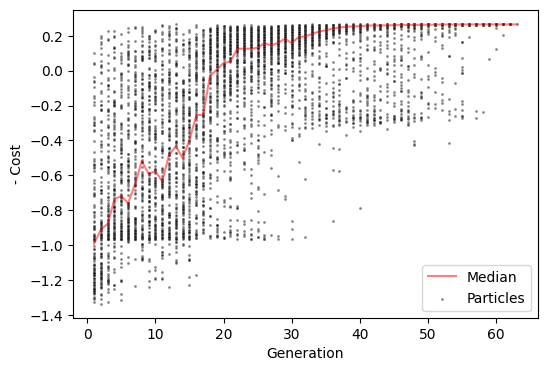

In [11]:
cmaes.plot_history('-cost')

We can also visualize how the global parameter $G$ and the regional values of parameters $w^{p}$ and $J^{N}$ evolve throughout the optimization using a GIF.

<div class="alert alert-info">
<p>
Note: The `cmaes.history` object stores only the 7 free parameters from the optimizer's point of view (i.e., `G` and baseline and map coefficients used for calculating regional parameters). To visualize the actual regional parameters in the code below, we must recalculate them. To do this, we use the `problem` `._get_X()` and `._get_sim_params()` methods to transform the optimizer’s parameters into full model parameter arrays for each particle. This is just a hack used for preparing the data used in the GIF, and is not needed during normal usage.
</p>
</div>

In [12]:
# transform history parameters to normalized space
hist_X = cmaes.problem._get_X(cmaes.history.loc[:, cmaes.problem.free_params])
# convert optimizer parameters (n = 7) to model parameters (n = 1 + 100 + 100)
# by calling `_get_sim_params()` method
hist_params = cmaes.problem._get_sim_params(hist_X)

In [13]:
import numpy as np
import imageio
import os
import tempfile
from tqdm import tqdm

# initialize the frames and temporary directory
frames = []
temp_dir = tempfile.mkdtemp()

# set a unified vmin and vmax for all the heatmaps
# note that upper limit is set to 95th percentile
# as there are some extreme outliers in the initial generations
# making the patterns in subsequent generations unclear
vmins = {
    'G': hist_params['G'].min(),
    'w_p': hist_params['w_p'].min(),
    'J_N': hist_params['J_N'].min()
}
vmaxs = {
    'G': np.quantile(hist_params['G'], 0.95),
    'w_p': np.quantile(hist_params['w_p'], 0.95),
    'J_N': np.quantile(hist_params['J_N'], 0.95)
}

# loop through each generation and save a frame
for gen in tqdm(range(cmaes.history['gen'].min(), cmaes.history['gen'].max() + 1)):
    # get the index of simulations in current generation
    curr_gen_idx = cmaes.history.loc[cmaes.history['gen']==gen].index
    if len(curr_gen_idx) < cmaes.popsize:
        continue
    # create the axes
    fig, axd = plt.subplot_mosaic(
        [["G"] + ["space0"] + ["w_p"] * 100 + ["title"] + ["J_N"] * 100],
        gridspec_kw=dict(width_ratios=[10] + [1] * 202),
        figsize=(6, 3), dpi=80
    )
    # plot separate heatmaps for each parameter
    sns.heatmap(hist_params['G'][curr_gen_idx, None], ax=axd['G'], cbar=False, cmap='viridis', vmin=vmins['G'], vmax=vmaxs['G'])
    axd['G'].set_title(r'$G$')
    sns.heatmap(hist_params['w_p'][curr_gen_idx, :], ax=axd['w_p'], cbar=False, cmap='viridis', vmin=vmins['w_p'], vmax=vmaxs['w_p'])
    axd['w_p'].set_title(r'$w^{p}$')
    sns.heatmap(hist_params['J_N'][curr_gen_idx, :], ax=axd['J_N'], cbar=False, cmap='viridis', vmin=vmins['J_N'], vmax=vmaxs['J_N'])
    axd['J_N'].set_title(r'$J^{N}$')
    # aesthetics
    axd['title'].set_title(f'Generation {gen}')
    for ax in axd.values():
        ax.axis('off')
    fig.subplots_adjust(wspace=0.5)
    # save frame
    frame_path = os.path.join(temp_dir, f'frame_{gen}.png')
    plt.savefig(frame_path)
    frames.append(frame_path)
    plt.close(fig)

# create the GIF
images = [imageio.imread(frame) for frame in frames]
imageio.mimsave('./cmaes_het.gif', images, fps=2, loop=0)

100%|██████████| 63/63 [00:36<00:00,  1.74it/s]
/tmp/ipykernel_49294/770299257.py:57: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(frame) for frame in frames]


![CMAES GIF](./cmaes_het.gif)

In this visualization, each row represents one particle (i.e., one simulation in a generation). For $w^{p}$ and $J^{N}$, each column corresponds to a node in the simulation. We observe that, toward the end of the optimization, the regional parameters stabilize into consistent spatial patterns, indicating convergence to a heterogeneous configuration that best fits the empirical data.

## Visualization of the optimal simulation

Lastly, we will visualize the simulated FC and FCD of the optimal simulation and compare them to the empirical data.

We can then plot the empirical FC next to the simulated FC. Note that at the end of the single-objective optimizations such as CMA-ES, `cmaes.problem.sim_group` contains a single simulation which is the optimum, therefore we can access its data by providing `0` as the simulation index.

Text(0.5, 1.0, 'Simulated FC')

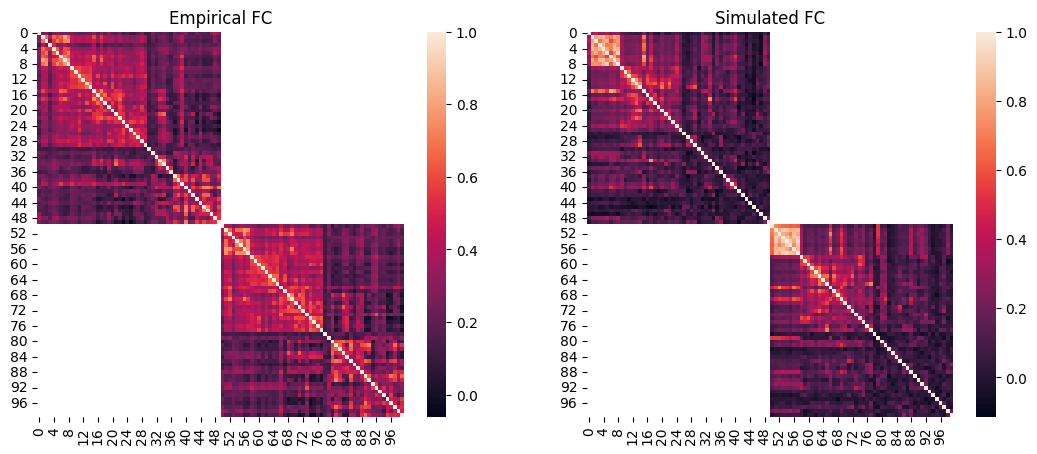

In [14]:
# load the squared form of the empirical FC
emp_fc = datasets.load_fc('schaefer-100', 'group-train706', exc_interhemispheric=True, return_tril=False)

opt_idx = 0

# load squared form of optimal simulated FC
sim_fc = cmaes.problem.sim_group.get_sim_fc(opt_idx)

# plot it next to the empirical FC
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(emp_fc, ax=axes[0])
axes[0].set_title("Empirical FC")
sns.heatmap(sim_fc, ax=axes[1])
axes[1].set_title("Simulated FC")

FC correlation = 0.5106505003041364


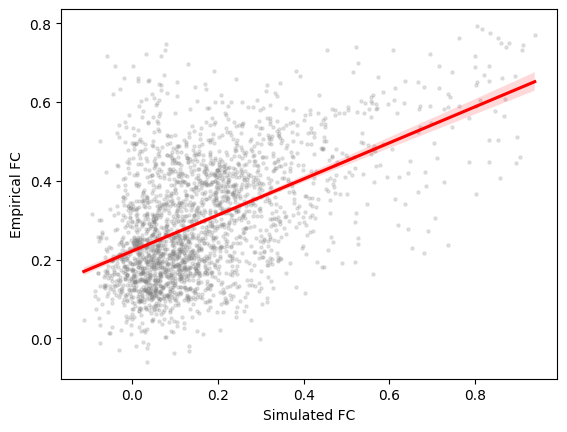

In [15]:
import scipy.stats
# regression plot
fig, ax = plt.subplots()
sns.regplot(
    x=cmaes.problem.sim_group.sim_fc_trils[opt_idx],
    y=emp_fc_tril,
    scatter_kws=dict(s=5, alpha=0.2, color="grey"),
    line_kws=dict(color="red"),
)
ax.set_xlabel("Simulated FC")
ax.set_ylabel("Empirical FC")

# calculate Pearson correlation
print(f"FC correlation = {scipy.stats.pearsonr(cmaes.problem.sim_group.sim_fc_trils[opt_idx], emp_fc_tril).statistic}")

In addition to static FC, we can also plot the simulated FCD matrix distribution next to the empirical data, and calculate their Kolmogorov-Smirnov distance:

FCD KS distance = 0.19805878033756402


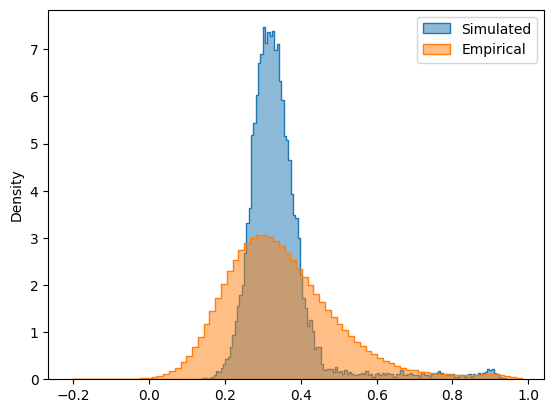

In [16]:
# plot the distributions next to each other
sns.histplot(cmaes.problem.sim_group.sim_fcd_trils[opt_idx], element='step', alpha=0.5, label='Simulated', stat='density')
ax = sns.histplot(emp_fcd_tril, element='step', alpha=0.5, label='Empirical', stat='density')
ax.legend()

# calculate KS distance
print(f"FCD KS distance = {scipy.stats.ks_2samp(emp_fcd_tril, cmaes.problem.sim_group.sim_fcd_trils[opt_idx]).statistic}")

The simulated and empirical FC and FCD are quantitatively compared using the FC correlation (`+fc_corr`), absolute mean difference of FCs (`-fc_diff`) and FCD KS distance (`-fcd_ks`). These metrics, along with the other cost function components and the parameters of the optimal simulation, are stored in `cmaes.opt`:

In [17]:
cmaes.opt

index           121.000000
G                 1.044188
w_p               1.869521
J_N               0.113597
w_pscale0        -0.129708
w_pscale1        -4.220957
J_Nscale0         4.994532
J_Nscale1        -4.746477
cost             -0.268861
+fc_corr          0.510651
-fcd_ks          -0.198059
+gof              0.312592
-fic_penalty     -0.043731
gen              13.000000
Name: 1657, dtype: float64

We observe that the optimal simulation obtained using the heterogeneous model has a lower cost and higher goodness-of-fit compared to the optimal point found with the [homogeneous model](cmaes_homo.ipynb).

This shows that introducing heterogeneity in regional parameters not only makes the model more biologically realistic (by allowing parameter values to vary across brain areas) but also can lead to a better fit to empirical data, consistent with findings of previous studies using similar heterogeneous models \[[Deco et al. 2021](https://doi.org/10.1126/sciadv.abf4752), [Demirtas et al. 2019](https://doi.org/10.1016/j.neuron.2019.01.017), [Kong et al. 2021](https://doi.org/10.1038/s41467-021-26704-y)\].